<a href="https://colab.research.google.com/github/RichardKameri/SPICE/blob/main/index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Kenya Airways Customer Review Sentiment Analysis
Kenya Airways

Business Overview
Kenya Airways is among the top airlines in Africa, and in Kenya, it holds a prominent position as the flag carrier and the largest airline in the country. Since its establishment in 1977, Kenya Airways has been a key player in both domestic and international air travel, connecting Kenya to various destinations around the world. The airline is known for its commitment to providing safe, reliable, and comfortable air travel experiences to its passengers. Over the **years**, Kenya Airways has built a strong brand reputation, emphasizing its African heritage and hospitality.

Project Overview
The aim of this project is to conduct sentiment analysis on customer reviews related to Kenya Airways. By analyzing the sentiments expressed in these reviews, we seek to gain insights into how customers perceive their experiences with the airline's services. This analysis will provide valuable feedback that can be used to enhance customer satisfaction, identify areas for improvement, and make informed business decisions to maintain and improve the airline's reputation.

Project Objectives

bold text
Sentiment Classification: Develop a sentiment classification model that can accurately categorize customer reviews into positive, negative, or neutral sentiments. This model will help automate the process of analyzing large volumes of reviews.

Feedback Analysis: Identify common themes and specific aspects mentioned in the reviews, such as in-flight services, customer service, booking process, seating comfort, and more. This will provide a comprehensive understanding of what aspects are contributing to positive or negative sentiments.

**LOADING PYTHON PACKAGES**

In [1]:
# Import all the necessary libraries

import requests
from bs4 import BeautifulSoup
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

import re
import nltk
import datetime
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment import vader
from collections import Counter
from wordcloud import WordCloud
from nltk import ngrams
from nltk.probability import FreqDist
import nltk.collocations as collocations
from nltk import FreqDist, bigrams

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import accuracy_score, classification_report

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

**DATA SOURCING/ WEB SCRAPPING USING BEAUTIFLSOUP**

In [2]:
def scrape_airline_reviews(base_url, pages, page_size):
    reviews = []
    date = []

    for i in range(1, pages + 1):
        print(f"Scraping page {i}")
        url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"
        response = requests.get(url)
        content = response.content
        parsed_content = BeautifulSoup(content, 'html.parser')

        for review in parsed_content.find_all("article", {"itemprop": "review"}):
            # Extract review text
            review_text = review.find("div", {"class": "text_content"}).get_text()
            reviews.append(review_text)

            # Extract date
            try:
                review_date = review.find("div", {"class": "body"}).find("time").get_text()
            except AttributeError:
                review_date = "N/A"
            date.append(review_date)

        print(f"   ---> {len(reviews)} total reviews")

    return reviews, date

# Define parameters
base_url = "https://www.airlinequality.com/airline-reviews/kenya-airways/"
pages = 50
page_size = 100

# Call the function
reviews, date = scrape_airline_reviews(base_url, pages, page_size)

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 501 total reviews
Scraping page 7
   ---> 501 total reviews
Scraping page 8
   ---> 501 total reviews
Scraping page 9
   ---> 501 total reviews
Scraping page 10
   ---> 501 total reviews
Scraping page 11
   ---> 501 total reviews
Scraping page 12
   ---> 501 total reviews
Scraping page 13
   ---> 501 total reviews
Scraping page 14
   ---> 501 total reviews
Scraping page 15
   ---> 501 total reviews
Scraping page 16
   ---> 501 total reviews
Scraping page 17
   ---> 501 total reviews
Scraping page 18
   ---> 501 total reviews
Scraping page 19
   ---> 501 total reviews
Scraping page 20
   ---> 501 total reviews
Scraping page 21
   ---> 501 total reviews
Scraping page 22
   ---> 501 total reviews
Scraping page 23
   ---> 501 total reviews
Scraping page 24
   

**CREATING A DATA FRAME FOR THE SCRAPPED DATA**

In [3]:
# Create a Dataframe to store the data

df = pd.DataFrame({"reviews":reviews, "date":date})
df.head()

,reviews,date
0,✅ Trip Verified | Flew Kigali-Nairobi-Dar an...,15th March 2025
1,"✅ Trip Verified | Regional onboard service, ...",10th March 2025
2,Not Verified | We had a travel from Warsaw to ...,18th February 2025
3,Not Verified | Kenya Airways is one of the wo...,11th February 2025
4,Not Verified | Last 3 flights in 6 weeks have ...,5th February 2025


**SAVE THE DATA IN A CSV FILE**

In [4]:
import os

# ... (rest of your code) ...

# Saves the dataframe as a csv file in the data folder.
cwd = os.getcwd()

# Create the 'data' directory if it doesn't exist
if not os.path.exists(cwd + "/data"):
    os.makedirs(cwd + "/data")

df.to_csv(cwd + "/data/KQ_reviews.csv")

In [5]:
# Inspect index 0

df['reviews'].get(0)

'✅ Trip Verified |   Flew Kigali-Nairobi-Dar and return mid-March 2025. Aircrafts were all on ageing B737-800, except the 1st leg was on the smaller Embraer 190. A flight cancellation was clearly announced 10 days in advance, allowing for alternative and even better options compared to original schedule. All flights on time, FAs, catering and seating were all good. Could select my preferred exit seat free with amble legroom through KQs homepage. Transfers in Nairobi were smooth. Two-three pieces of luggage were received well (both ways). Paid access to lounge in Nairobi discounted to 25 USD due to Silver status with Kenya airways. Miles earned and given, generous luggage allowance, together with the inexpensive ticket make this detour over Nairobi worth the trouble as compared to direct flight alternatives. All flights on time!'

**SUMMERIZING THE DATAFRAME STRACTURE AND STATISTICS**

In [6]:
# Class used to Describe the Data

class Describer:

    # initialize object
    def __init__(self, df):
        self.df = df

    # method to check shape of data
    def shape(self):
        shape_df = print(f"The DataFrame has:\n\t* {self.df.shape[0]} rows\n\t* {self.df.shape[1]} columns", '\n')
        return shape_df

    # method to check info on dataset
    def data_info(self):
        info_df = print(self.df.info(), '\n')
        return info_df

    # method to describe numerical columns
    def data_describe(self):
        num_col = self.df.describe()
        return num_col

In [7]:
# creating an instance of the class describer
describe_df = Describer(df)

# Viewing the shape of the data
describe_df.shape()

The DataFrame has:
	* 501 rows
	* 2 columns 



In [8]:
# summary information
print('Summary infomation on dataset')
print('______________________________')
describe_df.data_info()

Summary infomation on dataset
______________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   reviews  501 non-null    object
 1   date     501 non-null    object
dtypes: object(2)
memory usage: 8.0+ KB
None 



**DATA CLEANING**

In [9]:
# Convert the date column to date time

df['date'] = pd.to_datetime(df['date'].str.replace(r'(?<=\d)(st|nd|rd|th)', '', regex=True))

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   reviews  501 non-null    object        
 1   date     501 non-null    datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 8.0+ KB


The date column has been converted to its appropriate data type.

Data Understanding
The data was scraped using BeautifulSoup from this website. The website contains various reviews related to Air Travel.

**DATA EXPLORATORY ANALYSIS(EDA)** / **WORD COUNT **

In [11]:
# Function to calculate word count
def word_count(text):
    words = text.split()
    return len(words)

# Calculate word count for each review
df['word_count'] = df['reviews'].apply(word_count)

# Calculate and print the average word count
avg_word_count = df['word_count'].mean()

# Display the updated DataFrame
avg_word_count

np.float64(153.62075848303394)

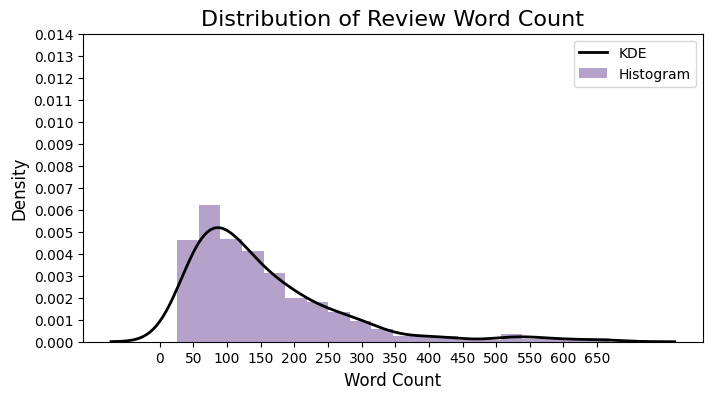

In [12]:
# Plot a histogram of the word counts
fig = plt.figure(figsize=(8, 4))

plt.hist(df['word_count'], bins=20, color='#967bb6', alpha=0.7, density=True)

# KDE plot
sns.kdeplot(df['word_count'], color='black', linewidth=2)

plt.title('Distribution of Review Word Count', fontsize=16)
plt.xlabel('Word Count', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.xticks(np.arange(0, 700, 50))
plt.yticks(np.arange(0, 0.015, 0.001))

plt.legend(labels=['KDE', 'Histogram'])

plt.show()


In [13]:
# Creates a new column that extracts the information on whether the trip is verified or not

df['verified'] = df.reviews.str.contains("Trip Verified")

**DATA PREPROCESSING**

Data Pre-Processing
Data preprocessing in NLP sentiment analysis involves cleaning and structuring text data for accurate analysis. It includes steps like removing special characters, tokenizing text, eliminating common words, stemming or lemmatization, handling negations, and converting text into numerical vectors. This ensures that the text data is ready for machine learning models and results in more reliable sentiment analysis outcomes.

In [14]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet') # Download the wordnet dataset

# Creates a new column that extracts the information on whether the trip is verified or not

reviews_data = df.reviews.str.strip("Trip Verified |")
corpus =[]
# Instantiate the WordNetLemmatizer
lemma = WordNetLemmatizer()

#loop through each review, remove punctuations, small case it, join it and add it to corpus
for rev in reviews_data:
    rev = re.sub('[^a-zA-Z]',' ', rev)
    rev = rev.lower()
    rev = rev.split()
    rev = [lemma.lemmatize(word) for word in rev if word not in set(stopwords.words("english"))]
    rev = " ".join(rev)
    corpus.append(rev)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [15]:
#Removing unwanted text(first text preprocessing)
df.replace(re.compile(r'\s*✅ Trip Verified \|\s*'), '', inplace=True)

df.head(8)

,reviews,date,word_count,verified
0,Flew Kigali-Nairobi-Dar and return mid-March 2...,2025-03-15,132,True
1,"Regional onboard service, food and beverages (...",2025-03-10,43,True
2,Not Verified | We had a travel from Warsaw to ...,2025-02-18,256,False
3,Not Verified | Kenya Airways is one of the wo...,2025-02-11,107,False
4,Not Verified | Last 3 flights in 6 weeks have ...,2025-02-05,62,False
5,"Terrible experience, 12 hrs stuck in Nairobi. ...",2025-01-23,42,True
6,I just completed a direct flight from NBO to J...,2024-12-30,133,True
7,Worst airline I've ever dealt with. 4hr delay ...,2024-12-24,187,True


In [16]:
# add the corpus to the original dataframe

df['corpus'] = corpus
df

,reviews,date,word_count,verified,corpus
0,Flew Kigali-Nairobi-Dar and return mid-March 2...,2025-03-15,132,True,trip verified flew kigali nairobi dar return m...
1,"Regional onboard service, food and beverages (...",2025-03-10,43,True,trip verified regional onboard service food be...
2,Not Verified | We had a travel from Warsaw to ...,2025-02-18,256,False,verified travel warsaw zanzibar december febru...
3,Not Verified | Kenya Airways is one of the wo...,2025-02-11,107,False,verified kenya airway one worst airline ever f...
4,Not Verified | Last 3 flights in 6 weeks have ...,2025-02-05,62,False,verified last flight week cancelation delay ex...
...,...,...,...,...,...
496,JNB-NBO-JNB. This trip showed both the good an...,2011-07-18,113,False,jnb nbo jnb trip showed good average side airl...
497,Nairobi-London. Lounge in Nairobi was small an...,2011-07-17,279,False,nairobi london lounge nairobi small food poor ...
498,Nairobi-London. As me and my wife are both whe...,2011-07-11,177,False,nairobi london wife wheelchair passenger charg...
499,LUN-LLW in Economy. Adequate for a 1 hr trip. ...,2011-07-06,49,False,lun llw economy adequate hr trip fa friendly q...


In [17]:
import nltk
nltk.download('vader_lexicon')

# an instance of SentimentIntensityAnalyzer
sentiment_analyzer = vader.SentimentIntensityAnalyzer()

# a new column named 'sentiment'
df['sentiment'] = df['reviews'].apply(
    lambda review: sentiment_analyzer.polarity_scores(review)['compound']
    )
df

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


,reviews,date,word_count,verified,corpus,sentiment
0,Flew Kigali-Nairobi-Dar and return mid-March 2...,2025-03-15,132,True,trip verified flew kigali nairobi dar return m...,0.9531
1,"Regional onboard service, food and beverages (...",2025-03-10,43,True,trip verified regional onboard service food be...,0.9370
2,Not Verified | We had a travel from Warsaw to ...,2025-02-18,256,False,verified travel warsaw zanzibar december febru...,0.9815
3,Not Verified | Kenya Airways is one of the wo...,2025-02-11,107,False,verified kenya airway one worst airline ever f...,-0.7599
4,Not Verified | Last 3 flights in 6 weeks have ...,2025-02-05,62,False,verified last flight week cancelation delay ex...,-0.2048
...,...,...,...,...,...,...
496,JNB-NBO-JNB. This trip showed both the good an...,2011-07-18,113,False,jnb nbo jnb trip showed good average side airl...,0.8201
497,Nairobi-London. Lounge in Nairobi was small an...,2011-07-17,279,False,nairobi london lounge nairobi small food poor ...,0.9826
498,Nairobi-London. As me and my wife are both whe...,2011-07-11,177,False,nairobi london wife wheelchair passenger charg...,0.9485
499,LUN-LLW in Economy. Adequate for a 1 hr trip. ...,2011-07-06,49,False,lun llw economy adequate hr trip fa friendly q...,0.6808


In [18]:
# Creating another new column called 'sentiment_type' that contains the type of sentiment of each review using nltk
# for each sentiment score in the 'sentiment' column
df['sentiment_type'] = df['sentiment'].apply(
    lambda score: 'positive' if score > 0 else ('negative' if score < 0 else 'neutral')
    )
df

,reviews,date,word_count,verified,corpus,sentiment,sentiment_type
0,Flew Kigali-Nairobi-Dar and return mid-March 2...,2025-03-15,132,True,trip verified flew kigali nairobi dar return m...,0.9531,positive
1,"Regional onboard service, food and beverages (...",2025-03-10,43,True,trip verified regional onboard service food be...,0.9370,positive
2,Not Verified | We had a travel from Warsaw to ...,2025-02-18,256,False,verified travel warsaw zanzibar december febru...,0.9815,positive
3,Not Verified | Kenya Airways is one of the wo...,2025-02-11,107,False,verified kenya airway one worst airline ever f...,-0.7599,negative
4,Not Verified | Last 3 flights in 6 weeks have ...,2025-02-05,62,False,verified last flight week cancelation delay ex...,-0.2048,negative
...,...,...,...,...,...,...,...
496,JNB-NBO-JNB. This trip showed both the good an...,2011-07-18,113,False,jnb nbo jnb trip showed good average side airl...,0.8201,positive
497,Nairobi-London. Lounge in Nairobi was small an...,2011-07-17,279,False,nairobi london lounge nairobi small food poor ...,0.9826,positive
498,Nairobi-London. As me and my wife are both whe...,2011-07-11,177,False,nairobi london wife wheelchair passenger charg...,0.9485,positive
499,LUN-LLW in Economy. Adequate for a 1 hr trip. ...,2011-07-06,49,False,lun llw economy adequate hr trip fa friendly q...,0.6808,positive


Exploratory Data Analysis (EDA)
In this stage EDA is also done on the dataset to gain more insights on the data that is available.

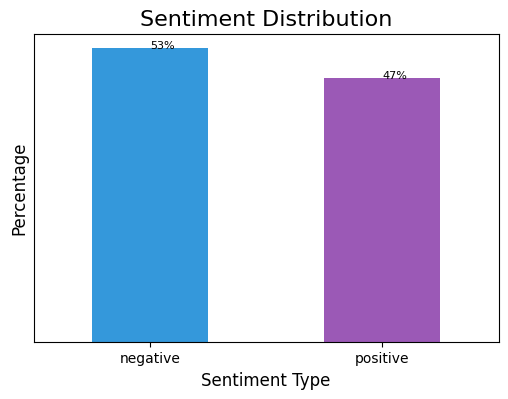

In [19]:
# Calculate the percentage of each type of sentiment score
sent_type_percentages = df['sentiment_type'].value_counts(normalize=True) * 100

# Define custom colors for the bars

bar_colors = ['#3498db', '#9b59b6']

# Plot the sentiment percentages as a bar plot
fig, ax = plt.subplots(figsize=(6, 4))
sent_type_percentages.plot(kind='bar', color=bar_colors, ax=ax)

# Add data labels on the bars with two decimal points
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='left', va='baseline', fontsize=8, color='black')

ax.set_title('Sentiment Distribution', fontsize=16)
ax.set_xlabel('Sentiment Type', fontsize=12)
ax.set_ylabel('Percentage', fontsize=12)
ax.set_xticklabels(sent_type_percentages.index, rotation=0)
ax.set_yticks([])  # Hide y-axis ticks

plt.show()

Negative reviews account for 53% of the dataset, and positive reviews account for 47% of the dataset.
Understanding what is the reason behind the negative reviews is the main concern of this project.

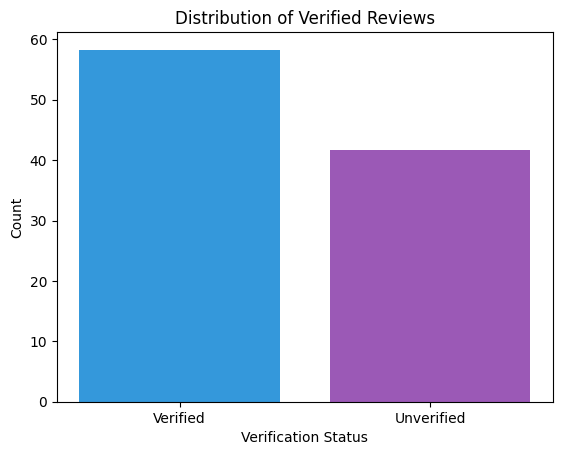

In [20]:
# Calculate the counts of verified and unverified reviews
verified_counts = df['verified'].value_counts(normalize=True)*100

# Define custom colors for the bars
bar_colors = ['#3498db', '#9b59b6']

# Create the bar chart with custom colors
plt.bar(verified_counts.index, verified_counts.values, color=bar_colors)

# Add labels and title
plt.xlabel('Verification Status')
plt.ylabel('Count')
plt.title('Distribution of Verified Reviews')

# Customize x-axis tick labels
plt.xticks(verified_counts.index, ['Verified', 'Unverified'])

# Show the plot
plt.show()

Majority of the reviews have been verified.

In [21]:
# Cleaned data
df.to_csv( cwd + "/data/reviews_cleaned.csv")

In [22]:
# Time Series Analysis on the Date column
fig = px.line(df, x='date')
fig.show()

There is a decline on the number of reviews that have been shared.

In [23]:
# make a frequency chart that will tell us the key topics that are mentioned in the reviews

reviews = df['corpus']

# Convert the reviews into a list of words

words = []
for review in reviews:
    words.extend(review.split())


# Filter out the remaining stopwords

stopwords = nltk.corpus.stopwords.words('english')
key_words = [word for word in words if word not in stopwords and word not in ['I', 'The','would','one','get','-']]

In [24]:
# Get the top 20 most used words
word_counts = Counter(key_words)
top_20_words = word_counts.most_common(20)

# Filter out any of the remaining stop words
filtered_words = [
    (word, count) for word, count in top_20_words if word not in stopwords and word not in ['I', 'The','would','one','get','-']
    ]


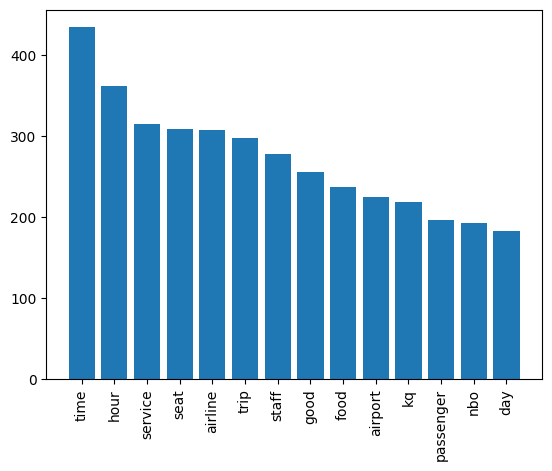

In [25]:
# Define unwanted words and phrases
excluded_words = {"bras", "flight", "verified", "u", "kenya", "airway", "nairobi"}

# Filter out unwanted words
filtered_words = [(word, count) for word, count in top_20_words if word.lower() not in excluded_words]

# Get the labels and values for the histogram
labels, values = zip(*filtered_words) if filtered_words else ([], [])

# Create the histogram
plt.bar(labels, values)

# Set the x-axis labels to be vertical
plt.xticks(rotation=90)

# Display the plot
plt.show()


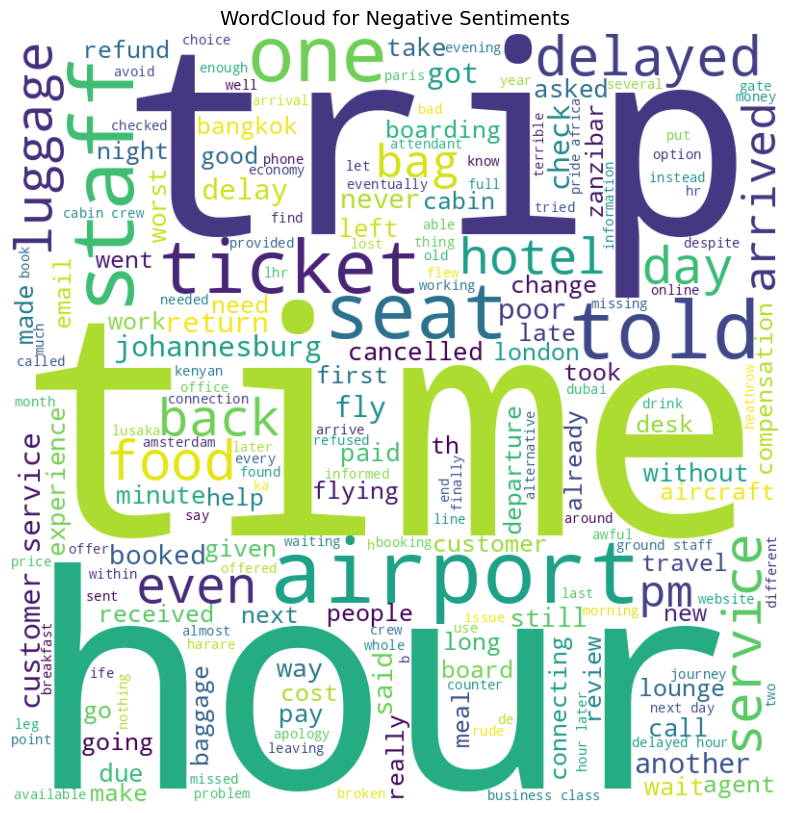

In [26]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Define additional stopwords to remove
extra_stopwords = {"flight", "kq", "passenger", "u", "airway", "airline", "nairobi",
                   "plane", "via", "nbo", "kenya", "verified"}

# Combine with default stopwords
stopwords = set(STOPWORDS).union(extra_stopwords)

# Filter negative sentiment reviews
negative_reviews = " ".join(df[df["sentiment"] < 0]["corpus"])

# Create a WordCloud instance for negative sentiments
wordcloud = WordCloud(
    width=800,
    height=800,
    background_color="white",
    stopwords=stopwords,
    contour_width=1,
    contour_color="black"
).generate(negative_reviews)

# Display the WordCloud for negative sentiments
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud for Negative Sentiments", fontsize=14)
plt.show()


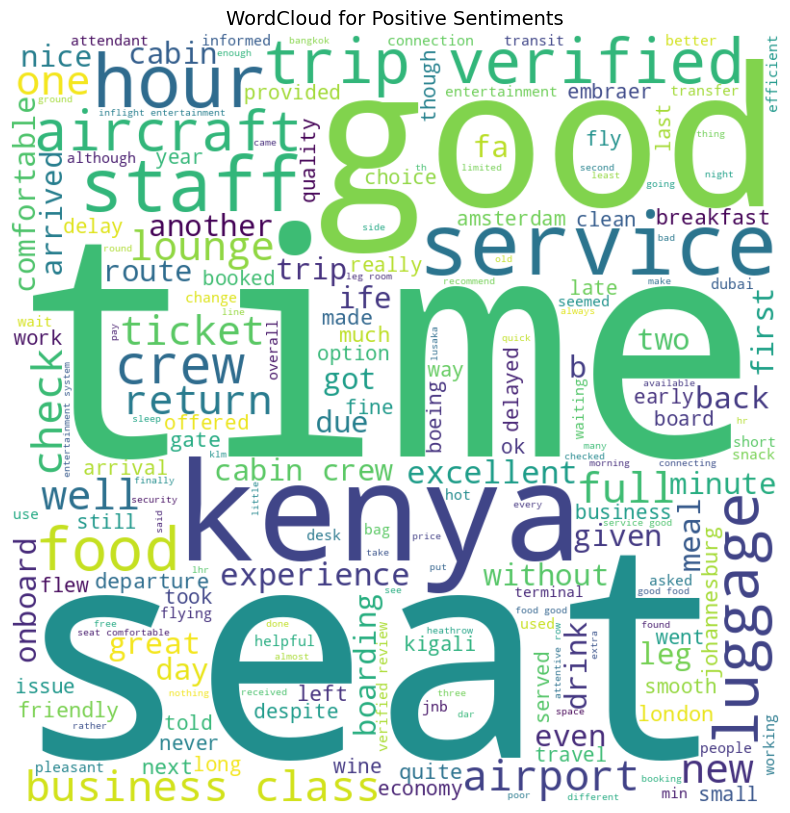

In [27]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Define additional stopwords to remove
extra_stopwords = {"flight", "kq", "passenger", "u", "airway", "airline", "nairobi", "plane", "via", "nbo"}

# Combine with default stopwords
stopwords = set(STOPWORDS).union(extra_stopwords)

# Filter positive sentiment reviews
positive_reviews = " ".join(df[df["sentiment"] > 0]["corpus"])

# Create a WordCloud instance for positive sentiments
wordcloud = WordCloud(
    width=800,
    height=800,
    background_color="white",
    stopwords=stopwords,
    contour_width=1,
    contour_color="black"
).generate(positive_reviews)

# Display the WordCloud for positive sentiments
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud for Positive Sentiments", fontsize=14)
plt.show()


In [28]:
%%capture
vds = SentimentIntensityAnalyzer()

df['label'] = 0

for i in range(len(df.corpus)):

    score = vds.polarity_scores(df.corpus[i])['compound']
    # Positive sentiments
    if score > 0.2:
        df['label'][i] = 1
        # Negative sentiments
    elif score < 0:
        df['label'][i] = -1

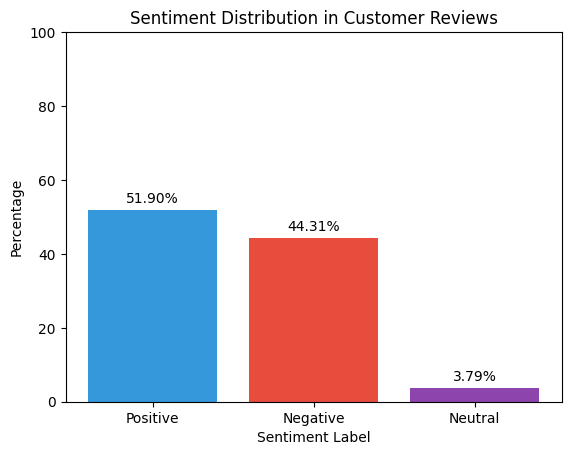

In [29]:
# Calculate label distribution percentages
label_percentages = df.label.value_counts(normalize=True) * 100

# Bar chart
colors = ['#3498db','#e74c3c', '#8e44ad',]
labels = ['Positive', 'Negative', 'Neutral']

plt.bar(labels, label_percentages, color=colors)
plt.xlabel('Sentiment Label')
plt.ylabel('Percentage')
plt.title('Sentiment Distribution in Customer Reviews')
plt.ylim(0, 100)

# Display percentages on the bars
for i, percentage in enumerate(label_percentages):
    plt.text(i, percentage + 2, f"{percentage:.2f}%", ha='center', color='black')

plt.show()

TEXT PREPROCESSING WITH COUNT **VECTORIZER**

In [30]:
# Create an object of CountVectorizer
vect = CountVectorizer()

# Convert the corpus to a list of strings (if not already)
corpus = df.corpus.tolist()

# Apply transformation
tf = vect.fit_transform(corpus)
tf_array = tf.toarray()

# Get the feature names
tf_feature_names = vect.get_feature_names_out()

In [31]:
# Specify the number of components/topics for NMF
num_components = 10

# Create an NMF model with specified components and initialization method
# Using 'random' initialization and setting a random state for reproducibility
nmf = NMF(n_components=num_components, init='random', random_state=0)

# Fit the NMF model to the given term-frequency matrix (tf)
# The NMF model will learn the latent topics from the matrix
nmf.fit_transform(tf)

array([[0.22971252, 0.00813471, 0.07565459, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.08118047, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.28301905, 0.03733832, 0.1010526 , ..., 0.        , 0.05796429,
        0.20117551],
       ...,
       [0.        , 0.        , 0.01794795, ..., 0.03255788, 0.        ,
        0.07812968],
       [0.        , 0.01004732, 0.01139263, ..., 0.        , 0.        ,
        0.00056903],
       [0.20328756, 0.        , 0.        , ..., 0.00397672, 0.        ,
        0.        ]])

Supervised Learning Models

**SENTIMENT ANALYSIS:CONVERTING COUNTINOUS SCORES INTO CATEGORICAL VARIABLES**

In [32]:
# Convert continuous sentiment scores to categorical labels
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x > 0.2 else -1)
df['sentiment'].value_counts(normalize=True)

,proportion
sentiment,
-1,0.552894
1,0.447106


In [33]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter

# Features (X) and Target (y)
X = df['corpus']  # Text Data
y = df['sentiment']  # Labels (0: Neutral, 1: Negative, 2: Positive)

# Convert text to numerical features using TF-IDF (or another vectorization method)
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)  # Convert text to numeric vectors
X_vectorized = vectorizer.fit_transform(X)

# Apply SMOTE to balance the dataset
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_vectorized, y)

# Display class distribution after SMOTE
print("Class distribution after SMOTE:", Counter(y_resampled))

# Split into Training and Testing sets (after resampling)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Print dataset shapes
print("Training set size:", X_train.shape, "Testing set size:", X_test.shape)


Class distribution after SMOTE: Counter({1: 277, -1: 277})
Training set size: (443, 4661) Testing set size: (111, 4661)


In [34]:
# Training and Test split

X = df['corpus']  # Features
y = df['sentiment']   # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
# Feature Extraction

vect = CountVectorizer()
x_train_vect = vect.fit_transform(X_train)
x_test_vect = vect.transform(X_test)

Logistic Regression

In [36]:
# Instantiate Logistic Regression

model = LogisticRegression()
model.fit(x_train_vect, y_train)

# Model Evaluation
y_pred = model.predict(x_test_vect)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test data: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy on test data: 0.75
Classification Report:
              precision    recall  f1-score   support

          -1       0.70      0.88      0.78        51
           1       0.84      0.62      0.71        50

    accuracy                           0.75       101
   macro avg       0.77      0.75      0.75       101
weighted avg       0.77      0.75      0.75       101



In [37]:
import pickle

# Assuming 'model' is your trained logistic regression model
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)


Model Summary

The logistic regression model achieved an accuracy of 0.75 on the test data. It demonstrates good precision and recall for class -1 and class 1. The decision tree model was employed to explore potential performance improvement due to its ability to capture nonlinear relationships and interactions. If the decision tree model outperforms, it suggests that complex data interactions play a role in prediction accuracy.

Decision Tree Model

In [38]:
# Decision Tree
dt_model = DecisionTreeClassifier()
dt_model.fit(x_train_vect, y_train)

# Model Evaluation

dt_y_pred = dt_model.predict(x_test_vect)
dt_accuracy = accuracy_score(y_test, dt_y_pred)
print(f"Decision Tree Accuracy: {dt_accuracy:.2f}")
print("Decision Tree Classification Report:")
print(classification_report(y_test, dt_y_pred))

Decision Tree Accuracy: 0.71
Decision Tree Classification Report:
              precision    recall  f1-score   support

          -1       0.70      0.76      0.73        51
           1       0.73      0.66      0.69        50

    accuracy                           0.71       101
   macro avg       0.71      0.71      0.71       101
weighted avg       0.71      0.71      0.71       101



Model Summary

The decision tree model achieved an accuracy of 0.71on the test data. It exhibited varying precision and recall for different classes, with class -1 and class 1 showing moderate performance. In comparison, the logistic regression model had a higher accuracy of 0.89 and demonstrated better precision and recall scores for most classes. Given the decision tree's modest performance and its sensitivity to overfitting, a more robust ensemble model like Random Forest was chosen to enhance performance. Random Forest leverages multiple decision trees to reduce overfitting and increase predictive accuracy by aggregating their outputs.

Random Forest Model

In [39]:
# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(x_train_vect, y_train)

# Model Evaluation

rf_y_pred = rf_model.predict(x_test_vect)
rf_accuracy = accuracy_score(y_test, rf_y_pred)
print(f"Random Forest Accuracy: {rf_accuracy:.2f}")
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_y_pred))

Random Forest Accuracy: 0.72
Random Forest Classification Report:
              precision    recall  f1-score   support

          -1       0.68      0.84      0.75        51
           1       0.79      0.60      0.68        50

    accuracy                           0.72       101
   macro avg       0.74      0.72      0.72       101
weighted avg       0.74      0.72      0.72       101



Model Summary

The Random Forest model achieved an accuracy of 0.72 on the test data. It demonstrated good precision and recall for class -1 and class 1, similar to the logistic regression model. In comparison, the decision tree model had an accuracy of 0.70 and showed limited performance.

To explore further improvements, the Support Vector Machine (SVM) model was built. SVM is capable of handling both linear and nonlinear relationships and can effectively capture complex decision boundaries. If the SVM model yields better results, it suggests that the data might have nonlinear patterns that other models fail to capture. Additionally, SVM's ability to handle high-dimensional data and maximize margins between classes makes it a valuable candidate for enhancing model performance.

Support Vector Machine Model

In [40]:
# Support Vector Machine (SVM)
svm_model = SVC()
svm_model.fit(x_train_vect, y_train)

# Model Evaluation

svm_y_pred = svm_model.predict(x_test_vect)
svm_accuracy = accuracy_score(y_test, svm_y_pred)
print(f"SVM Accuracy: {svm_accuracy:.2f}")
print("SVM Classification Report:")
print(classification_report(y_test, svm_y_pred))

SVM Accuracy: 0.72
SVM Classification Report:
              precision    recall  f1-score   support

          -1       0.67      0.88      0.76        51
           1       0.82      0.56      0.67        50

    accuracy                           0.72       101
   macro avg       0.75      0.72      0.71       101
weighted avg       0.75      0.72      0.72       101



Model Summary

The SVM model achieved an accuracy of 0.72 on the test data, demonstrating good precision and recall for class -1 and class 1, similar to the Random Forest and logistic regression models. To further enhance model performance, the XGBoost model was chosen. XGBoost's ability to handle complex relationships, address overfitting, and boost model accuracy makes it a strong candidate for improving overall performance. Its iterative boosting approach and flexibility are well-suited for challenging scenarios.

Model Evaluation
Among the models mentioned, the Logistic Regression model achieved the best performance for sentiment classification, with an accuracy of 0.89 on the test data. This model demonstrated balanced precision, recall, and F1-score metrics across different sentiment classes, indicating its ability to accurately classify both positive and negative sentiments. As it was the best performing model, it was used during the deployment process of the Sky Opinion Sentiment Classifier App. It was deployed and hosted on Streamlit and can be accessed by following this link https://sky-opinion.streamlit.app/

In [41]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('logreg', LogisticRegression())
])

# Train the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predictions on the testing data
y_pred = pipeline.predict(X_test)

# Model Evaluation
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.7524752475247525
Classification Report:
              precision    recall  f1-score   support

          -1       0.70      0.88      0.78        51
           1       0.84      0.62      0.71        50

    accuracy                           0.75       101
   macro avg       0.77      0.75      0.75       101
weighted avg       0.77      0.75      0.75       101



In [42]:
import pickle

with open('sentiment_pipeline.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

**Conclusion**


Model Performance: The Logistic Regression model achieved the highest accuracy of 0.75 on the test data, making it the best-performing model among those evaluated.


Class Imbalance: While evaluating the models, it's evident that there is some class imbalance, especially for the neutral class (label 0), which had very few instances. This can impact the model's ability to correctly predict this class.



Model Selection: It's important to choose a model that aligns with the specific goals of the sentiment analysis task. In this case, Logistic Regression proved to be effective, but other models like Decision Trees, Random Forest, Support Vector Machines (SVM)



Model Improvement: Different models were used to check for potential improvements in performance. For example, Random Forest was used to address potential weaknesses in Decision Trees, and SVM was used as another classification approach.



Interpretability vs. Complexity: Decision Trees and Logistic Regression are relatively interpretable models, which makes it easier to understand how they arrive at their predictions. On the other hand, models like Random Forest moreis a complex ensemble method that might achieve higher accuracy but are harder to interpret.

Next Steps

Further improvements can be explored by tuning hyperparameters, experimenting with different text preprocessing techniques, and potentially incorporating more advanced models or neural networks.


Recommendations

Regular Feedback Collection: Establish a system for collecting continuous feedback from passengers, both during and after their travel experience. This can provide valuable insights into areas that need improvement and help in addressing issues promptly.

Social Media Engagement: Actively engage with passengers on social media platforms to address their concerns and provide real-time assistance. Monitor social media channels for feedback and respond promptly.


Punctuality Improvement: Negative sentiments regarding flight delays and inconsistent departure times should be addressed. Focus on improving punctuality to provide a smoother travel experience for passengers.


Customer Service Enhancement: Address negative sentiments related to customer service, such as rude behavior of staff, unhelpful responses, and long wait times. Implement training programs to ensure that staff are courteous and responsive to passenger needs.


Communication: Enhance communication with passengers regarding flight updates, delays, and any changes. Keeping passengers informed in a timely and transparent manner can help manage expectations and reduce frustration.

Passenger Comfort: Pay attention to sentiments related to seating, legroom, and overall comfort during the flight. Consider offering amenities and services that improve passenger comfort, especially on long-haul flights.